# Quantum Information and Computing
## Tensor networks as neural network layers for supervised learning

### Index

1. Introduction
2. Classification using tensor networks
    - Simple tensor network: Toy model
    - MNIST handwritten digits
    - Convolutional MPO's: Fruit and vegetable recognition
3. Comparison with standard neural networks
    - Fully-connected networks
    - Convolutional networks

## Introduction

# ##Placeholder for intro block##

## Classification using tensor networks

In order to simplify computational tasks, a combination of the modules ```TensorFlow``` and ```TensorNetwork``` has been used.

- [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf), [source](https://github.com/tensorflow/tensorflow)
- [TensorNetwork documentation](https://tensornetwork.readthedocs.io/en/latest/), [source](https://github.com/google/TensorNetwork)

### Basic toy model

#### Data generation

In [1]:
from final import *
%load_ext autoreload
%autoreload 2


import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


fig_dict = dict()


In [2]:
unit_sq = np.mgrid[0:1:.001, 0:1:.001]

#Initialize multivar gaussian distributions
rv_tL = mv_norm([0., 1.], [[0.1, 0], [0., 0.15]]) #top-Left gaussian
rv_bR = mv_norm([1., 0.], [[0.175, 0], [0., 0.09]]) #bottom-Right gaussian

#Generate the multivariate density functions
pos = np.dstack(unit_sq)
dist1 = rv_tL.pdf(pos)
dist2 = rv_bR.pdf(pos)

#Compute the optimal theoretical boundary
x_vals, y_est = optimal_boundary(dist1, dist2, unit_sq, tolerance=1e-4)

#Generate data samples and labels to use in the classification task.
x1, labels1, x2, labels2 = gen_samples(1000, rv_tL, rv_bR)
x, labels = np.vstack([x1,x2]), np.vstack([labels1,labels2]).flatten()


#Generate random shuffler for the data
shuffler = np.random.permutation(len(x))
x, labels = x[shuffler], labels[shuffler]
#shuffle and split data into training and test sets.
x_train, x_test, labels_train, labels_test = train_test_split(x, labels, test_size=0.2, random_state=420)

For this toy model, the objective function is chosen as the binary negative logarithm loss. Because of this, the output ought to have two components, each indicating the likelihood of predicting either label. These are obtained at the free index of the tensor network, upon application of a softmax activation on the resulting tensor components.

The model will aim to approximate the separating curve as illustrated in the plots below. This is the theoretical optimal separating plane, defined as the set of locations where the two distributions are equal $-$ where a classifier will predict either class with equal probability.

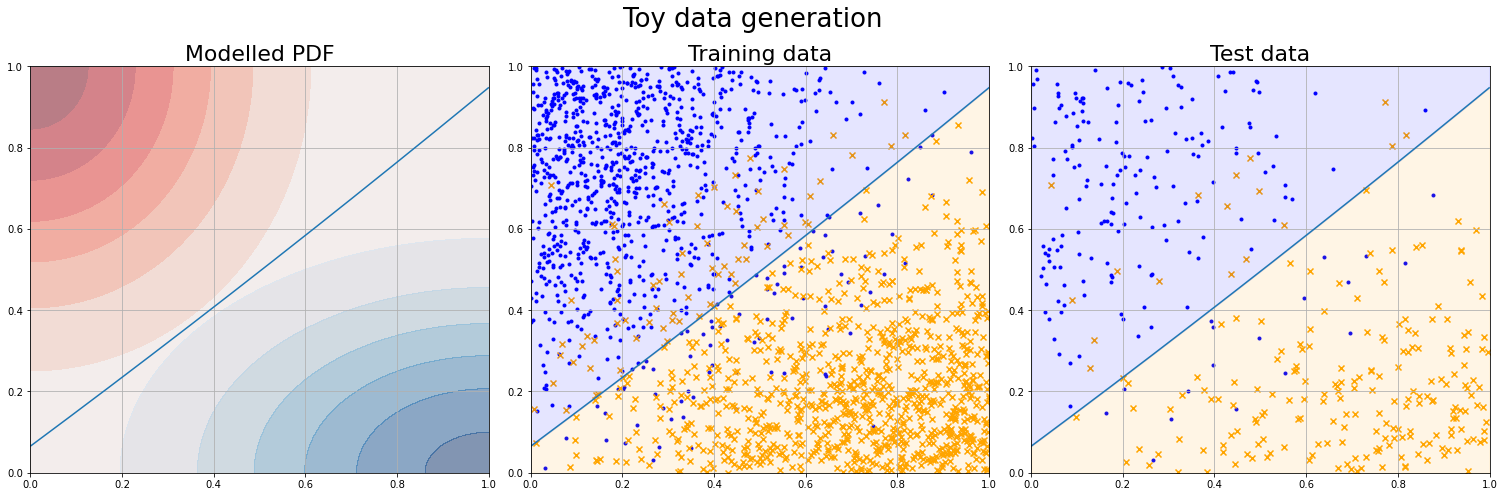

In [3]:
toy_plot = toy_model_plot(unit_sq, dist1, dist2, x_vals, y_est, x1, x2, x_test, labels_test)
fig_dict['toy_plot'] = toy_plot

#### Feature mapping

The matrix product state will have as many nodes as feature inputs. Having two dimensional data $(x_1, x_2)$, the feature map will have rank 2:

$$
\Phi(x_1, x_2) = \phi^{s_1}(x_1) \otimes \phi^{s_2}(x_2)
$$

Where $\phi(\cdot)$ is a feature map $\phi : \mathbb{R} \rightarrow \mathbb{R^d}$ where $d$ is the number of components of each index $s_{i}$ of the input $\Phi$. The impact of this value will be studied further.

The mapping is chosen as follows:
$$
\phi(x)_{s_i} = \sqrt{\binom{d - 1}{s_i - 1}} \cos^{d - s_i}\left(\frac{\pi}{2}x \right) \sin^{s_i - 1}\left(\frac{\pi}{2}x\right)
$$

It can be promptly shown that this mapping will be normalized to unity for any value of $d$.

In [4]:
d=3
#Feature mapping dataset
x_ftrain, y_htrain, x_ftest, y_htest = fmap(d, x_train, x_test, labels_train, labels_test)

toy_train_ds = tf.data.Dataset.from_tensor_slices((x_ftrain, y_htrain)).shuffle(100).batch(16)
toy_test_ds = tf.data.Dataset.from_tensor_slices((x_ftest, y_htest)).shuffle(100).batch(16)


In [5]:
toy_train_ds.element_spec[0]

TensorSpec(shape=(None, 3, 3), dtype=tf.float64, name=None)

The tensor network is defined as a ```Keras``` model of a single layer. This allows for easy implementation of different algorithms of gradient descent and the respective back-propagation.

The layer is defined as a subclass of ```tensorflow.keras.layers.Layer```, inheriting its methods and attributes. The number of nodes in the matrix product state (MPS) equals the dimensionality of the input: an $N$-dimensional input will yield a tensor of rank $N$. With two-dimensional toy data, we use two MPS tensors. The bond dimension can be tuned as a hyper-parameter of the model. A larger bond dimension will, in principle, augment the classifier's predictive power.

2022-03-09 02:35:21.687386: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


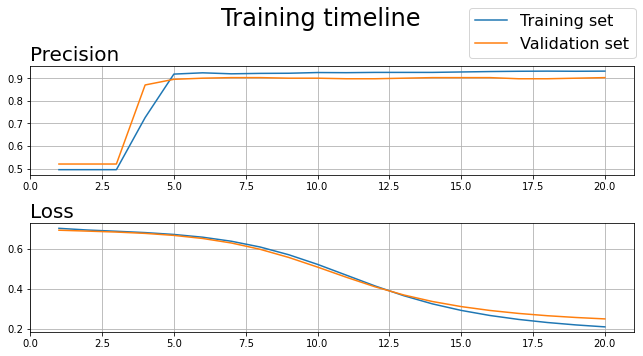

In [6]:
#model training

bond_dim = 5
tnetwork = build_model(d, bond_dim, 'SGD', batch_size=None)

check_point = ModelCheckpoint(filepath = os.getcwd()+'/saved_models/tn_toy.tf', verbose = 0, save_best_only = True)
toy_history = tnetwork.fit(toy_train_ds, validation_data=toy_test_ds, epochs=20, verbose=0, shuffle=True, callbacks=[check_point])

with open(os.getcwd()+'/hists/tn_MNIST_hist.json', 'w') as f:
    json.dump(toy_history.history, f)
#plotting history
history_plot = plot_loss_acc(toy_history.history, figsize = (9, 5), tight_layout='pad')
fig_dict['toy_history'] = history_plot

The loss quickly converges to a finite value after $40$ epochs. The model reaches a precision of about 90% with $(d,m) = (3,5)$.

The two hyperparameters can be tuned through a grid search. All the combinations of values $(d,m)$ with $d \in \{2, 4, 7\}$ and $m \in \{2,5,11\}$ were tested. The plots below illustrate their effect on overfitting.

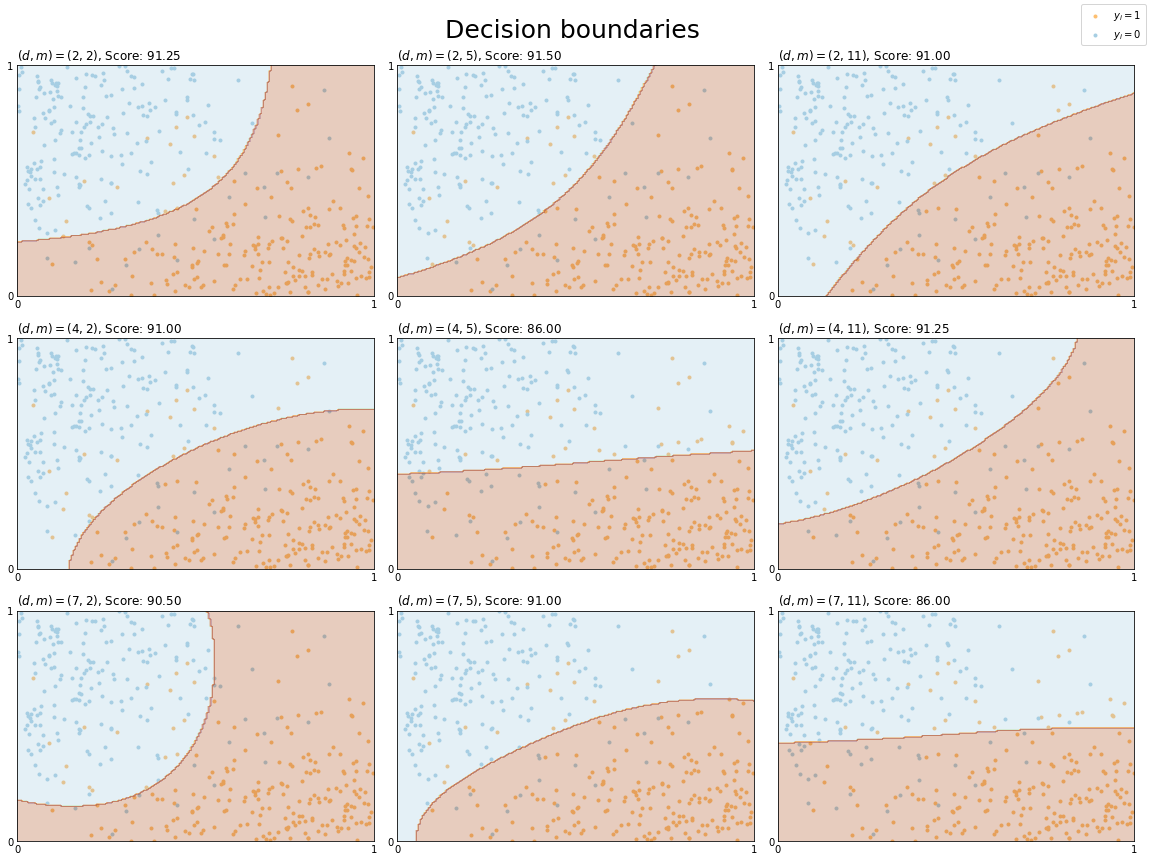

In [7]:
m_list = [2, 5, 11]
d_list = [2, 4, 7]

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

fig_contours, _ = decision_contours(d_list, m_list, x_train, x_test, labels_train, labels_test, n_epochs=20, figsize=(16,12), tight_layout='pad')
fig_dict['toy_contours'] = fig_contours

A larger dimensionality $d$ of the feature mapping $\phi$ causes the model to overfit. Overall, a larger bond dimension increases the model accuracy. However, it also causes further overfitting when more extreme values are used.

The effect of larger values for these parameters would likely be more meaningful when attempting to classify data of higher dimensionality. The advantage of the matrix product state lies precisely in its ability to achieve tensor representations with lower number of parameters.

### MNIST Handwritten digits

The MNIST handwritten digits dataset is standard for proof-of-concept in classification models. Convolutional neural networks are traditionially applied for image classification, being capable of perceiving relationships between closely neighboring features. These have low complexity by nature. However, the output of the model eventually needs to be flattened and reduced to the number of classes. This is achieved by applying fully connected layers, which we replace with simple matrix product states.

Each sample is originally $28\times 28$ pixels on a single channel, with integer values ranging from $0$ to $255$, which are scaled to a $[0,1]$ range. This prevents neurons from saturating. These are downsampled by averaging each cluster of $2\times 2$ pixels in the input. This can be quickly achieved by directly applying ```keras.layers.AveragePooling2D``` on the normalized input. The labels are one-hot encoded in order to obtain a softmax output.

This feature reduction aims to reduce the training time of the model.

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist.npz')


x_train, x_test = x_train.reshape((60000, 28, 28, 1))/255, x_test.reshape((10000, 28, 28, 1))/255

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)
avg_input = tf.keras.layers.AveragePooling2D((2,2))



x_train_red, x_val_red, x_test_red = avg_input(x_train), avg_input(x_val), avg_input(x_test)

mnist_train = tf.data.Dataset.from_tensor_slices((x_train_red, tf.one_hot(y_train, 10))).shuffle(100).batch(3000)
mnist_val   = tf.data.Dataset.from_tensor_slices((x_val_red, tf.one_hot(y_val, 10))).shuffle(100).batch(len(x_val))
mnist_test  = tf.data.Dataset.from_tensor_slices((x_test_red, tf.one_hot(y_test, 10))).batch(len(x_test))
in_shape_mnist = x_train_red[0].shape

The model architecture is elementary. A single classic convolutional layer, followed by max-pooling is used before connecting the flattened output to a tensor network, which replaces a hidden dense layer of $256$ neurons. Its output feeds into a classic fully connected layer which performs softmax activation.

In [9]:
tn_MNIST = tf.keras.Sequential(
    [
     tf.keras.Input(shape=in_shape_mnist),
     Conv2D(filters=28, kernel_size=(2,2), strides=1, name='conv1', activation='relu', activity_regularizer=regularizers.l2(1e-4)),
     MaxPooling2D((2,2), name='maxpool1'),
     Flatten(),
     MNIST_TN(bond_dim = 11, activity_regularizer=regularizers.l2(1e-5)),
     Dense(10, activation='softmax', name='out_layer')])
tn_MNIST.summary()

tn_MNIST.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 13, 13, 28)        140       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 6, 6, 28)          0         
                                                                 
 flatten (Flatten)           (None, 1008)              0         
                                                                 
 mnist_tn (MNIST_TN)         (None, 256)               14160     
                                                                 
 out_layer (Dense)           (None, 10)                2570      
                                                                 
Total params: 16,870
Trainable params: 16,870
Non-trainable params: 0
_________________________________________________________________


In [10]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/saved_models/tn_MNIST.tf', verbose = 0, save_best_only = True)


hist_dict = tn_MNIST.fit(mnist_train, validation_data=mnist_val, epochs = 50, verbose = 0, shuffle=True, callbacks=[check_point])

with open(os.getcwd()+'/hists/tn_MNIST_hist.json', 'w') as f:
    json.dump(hist_dict.history, f)

In [11]:
loaded_MNIST = tf.keras.models.load_model(os.getcwd()+'/saved_models/tn_MNIST.tf')


prediction_prob = tn_MNIST.predict(mnist_test)
prediction = np.argmax(prediction_prob, axis=1)

correct_indices = y_test[prediction == y_test]
incorrect_indices = y_test[prediction != y_test]

_, score = tn_MNIST.evaluate(mnist_test)
print(f"Model scored with {score*100.:2f}% precision on the test set.")

1/1 [==============================] - 0s 164ms/step - loss: 0.0759 - precision: 0.9836
Model scored with 98.357683% precision on the test set.


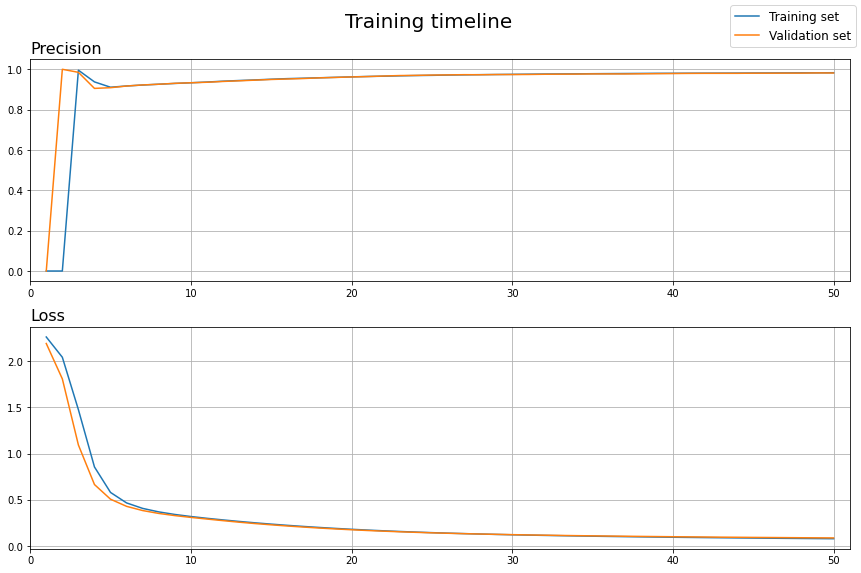

In [12]:
tn_mnist_fig = plot_loss_acc(hist_dict.history, starting_epoch=1, fontsize=16, figsize= (12,8), tight_layout='pad')

fig_dict['mnist_tn'] = tn_mnist_fig

The model quickly starts overfitting. This effect may be mitigated by applying any traditional techniques such as batch normalization, intermediate drop-out, or stronger regularizers.

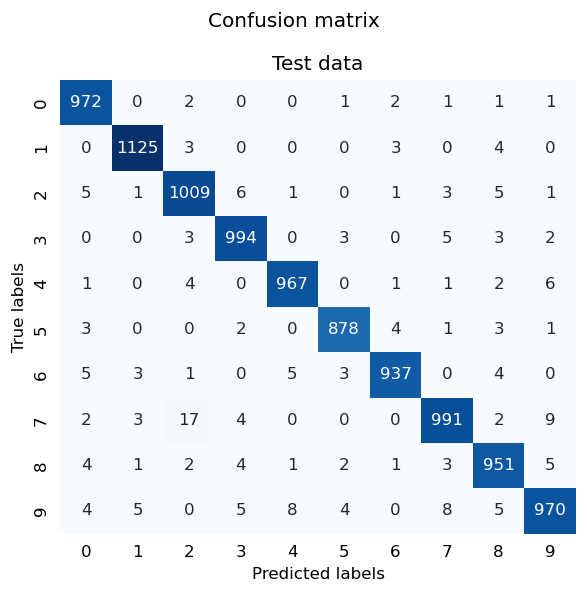

In [13]:
conf_matrix = confusion_matrix(y_test, prediction)
mat_fig, mat_axs = show_conf_matrix(conf_matrix, "Test data", dpi=120, figsize=(5,5), tight_layout='pad')

mat_fig.show()

fig_dict['mnist_conf'] = mat_fig

Generally, the model classified with a solid accuracy. The larger groups of misclassified samples are likely due to subtle differences in the samples, which the classifier cannot seem to discern.

### Fruit and vegetable recognition

To test advanced tensor network architectures, a more complex dataset was selected. The fruit and vegetable dataset includes $131$ classes. The input is downsized from $100 \times 100$ to $50 \times 50$. Each sample is composed of the three RGB channels.

This data set was chosen due to its large label set, serving as a limiting case of the predictive power of simpler models. We employ an architecture corresponding to a larger number of parameters, to emphasize the reduction of trainable weights when using matrix product states. We also introduce matrix product operators, based on similar principles, to store the convolution filters with lower number of parameters.

In [14]:
train_dir = os.getcwd() + "/fruits360/Training"
test_dir  = os.getcwd() + "/fruits360/Test"
batch_size = 3000
img_height = 50
img_width = 50
validation_split = 0.2
#Ideally, we want the batch to be large enough to contain at least one sample
#of each class
#Otherwise the model makes conclusions before seeing all types of data

train_ds, val_ds, test_ds = load_fruits_dataset(train_dir, test_dir, validation_split, batch_size, img_height, img_width)


Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.

Test data:
Found 22688 files belonging to 131 classes.


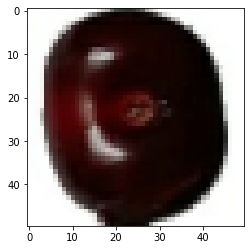

Label : 26


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_train, labels_batch_train = next(iter(normalized_ds_train))

normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_ds_val))

first_image = image_batch_train[0]
in_shape_fruits = first_image.shape

plt.imshow(first_image)
plt.show()
print(f"Label : {np.argmax(labels_batch_train[0])}")

The architecture of the model consists of a classic convolutional layer, followed by two convolutional matrix product operators (MPO). These function as traditional layers, while simultaneously storing the kernel as a MPO. These layers' outputs are pooled and finally sent to MPS equivalent to fully connected layers of $64$ and $131$ neurons, respectively.

In [16]:
#Building the tensor network
tn_reg_dense = regularizers.l2(1e-5)
tn_reg_conv  = regularizers.l2(1e-5)

tn_fruits = tf.keras.Sequential([
  Input(in_shape_fruits),
  Conv2D(4, kernel_size=4),
  Conv2DMPO(16, data_format = "channels_last", kernel_size=2, num_nodes=2, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  fruit_TN1(bond_dim = 5, activity_regularizer = tn_reg_dense),
  tf.keras.layers.Dropout(0.5, name='dropout1'),
  fruit_TN2(bond_dim = 4, activity_regularizer = tn_reg_dense),
  ])

tn_fruits.summary()

lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.5)
#The loss was blowing up, meaning the training was reaching a point where
#the learning rate was too large, so I wrote it with a schedule which makes it
#decay to 10% every 500 training steps (batch runs)
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
tn_fruits.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 47, 4)         196       
                                                                 
 conv2dmpo (Conv2DMPO)       (None, 47, 47, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 conv2dmpo_1 (Conv2DMPO)     (None, 23, 23, 256)       1536      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 fruit_tn1 (fruit_TN1)       (None, 64)               

In [17]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/saved_models/tn_fruits.tf', verbose = 0, save_best_only = True)

tn_fruits_history = tn_fruits.fit(train_ds, validation_data=val_ds, epochs = 20, verbose = 0, shuffle=True, callbacks=[check_point])

with open(os.getcwd()+"/hists/tn_fruit_history.json", 'w') as f:
    json.dump(tn_fruits_history.history, f)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/fruit_tn2/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/fruit_tn2/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/fruit_tn2/loop_body/GatherV2/pfor/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/fruit_tn1/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/fruit_tn1/loop_body/GatherV2/pfor/Resha

In [18]:
loaded_tn_fruits = tf.keras.Sequential([
  Input(in_shape_fruits),
  Conv2D(4, kernel_size=4),
  Conv2DMPO(16, data_format = "channels_last", kernel_size=2, num_nodes=2, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  fruit_TN1(bond_dim = 5, activity_regularizer = tn_reg_dense),
  tf.keras.layers.Dropout(0.5, name='dropout1'),
  fruit_TN2(bond_dim = 4, activity_regularizer = tn_reg_dense),
  ])

loaded_tn_fruits.load_weights(os.getcwd()+'/saved_models/tn_fruits.h5')
opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
loaded_tn_fruits.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['Precision'])

8/8 [==============================] - 71s 317ms/step - loss: 1.2213 - precision: 0.8080


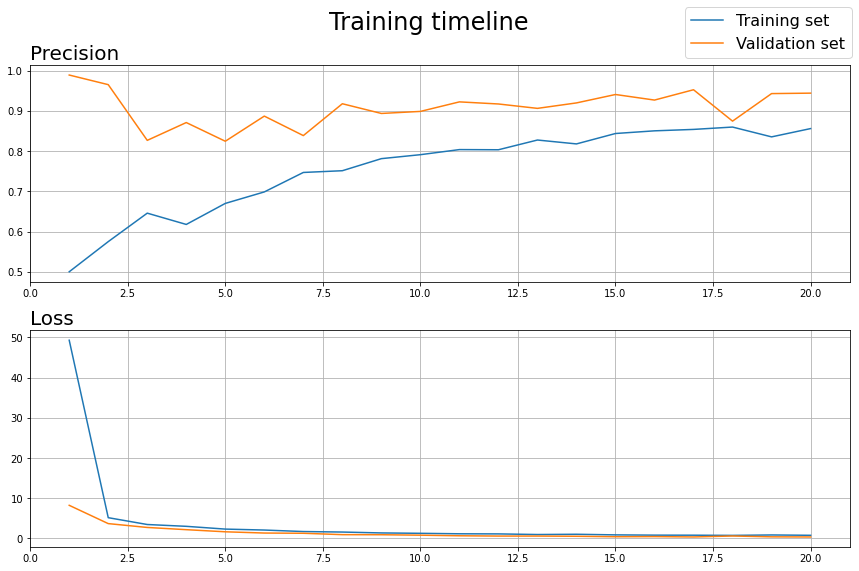

In [19]:
loaded_tn_fruits.evaluate(test_ds)  ####print and format
tn_fruits_plot = plot_loss_acc(tn_fruits_history.history, starting_epoch = 1, figsize=(12,8), tight_layout='pad')

fig_dict['tn_fruits'] = tn_fruits_plot

## Comparison with traditional neural networks

All the traditional network architectures have been chosen to be equivalent to those defined with tensor networks.

### MNIST

In [20]:
reg = regularizers.l2(0.005)
init = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.Nadam(learning_rate = 0.01)


classic_mnist = tf.keras.Sequential()
classic_mnist.add(Conv2D(filters = 28, kernel_size = (2,2), strides=1, activation = 'relu', input_shape=(14,14,1), activity_regularizer = reg))
classic_mnist.add(MaxPooling2D(pool_size = (2, 2), strides = 2))

classic_mnist.add(Flatten())
classic_mnist.add(Dropout(0.3))
classic_mnist.add(Dense(256,activation = 'relu'))
classic_mnist.add(Dense(10,activation = 'softmax'))

classic_mnist.summary()
classic_mnist.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = opt, metrics = ['Precision'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 13, 13, 28)        140       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 28)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1008)              0         
                                                                 
 dropout (Dropout)           (None, 1008)              0         
                                                                 
 dense (Dense)               (None, 256)               258304    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                      

In [21]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/saved_models/trad_MNIST.tf', verbose = 0, save_best_only = True)
class_mnist_hist = classic_mnist.fit(mnist_train, validation_data=mnist_val, epochs = 10, verbose = 0, shuffle=True, callbacks=[check_point])


with open(os.getcwd()+'/hists/trad_MNIST_hist.json', 'w') as f:
    json.dump(class_mnist_hist.history, f)

1/1 [==============================] - 0s 76ms/step - loss: 0.0786 - precision: 0.9831
Classic model scored 98.310% in test set


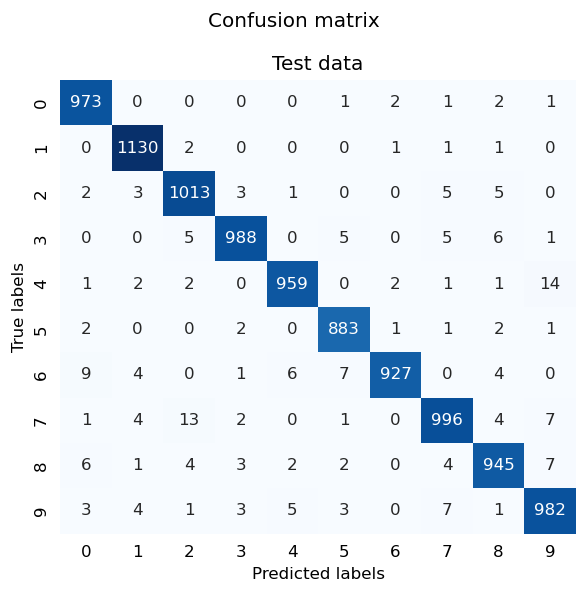

In [22]:
class_prediction = classic_mnist.predict(mnist_test)
prediction = np.argmax(class_prediction, axis=1)
conf_matrix = confusion_matrix(y_test, prediction)
mat_fig, mat_axs = show_conf_matrix(conf_matrix, "Test data", dpi=120, figsize=(5,5), tight_layout='pad')

mat_fig.show()

fig_dict['mnist_conf'] = mat_fig

loss, score = classic_mnist.evaluate(mnist_test)

print(f"Classic model scored {score*100:.3f}% in test set")

### Fruits and vegetables

In [23]:
#Defined a model using some layer regularizers to avoid overfitting
classical_fruit = tf.keras.Sequential([
  tf.keras.Input(shape=in_shape_fruits),
  tf.keras.layers.Conv2D(4, kernel_size=4),
  tf.keras.layers.Conv2D(16, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv1'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool1'),
  tf.keras.layers.Conv2D(256, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv2'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool2'),
  tf.keras.layers.Flatten(name='flatten1'),
  tf.keras.layers.Dropout(0.5, name='dropout1'),
  tf.keras.layers.Dense(64, activation = 'relu', name='dense1'),
  tf.keras.layers.Dropout(0.2, name='dropout2'),
  tf.keras.layers.Dense(131, activation='softmax', name='out_dense')
])


classical_fruit.summary()


lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.1)
#The loss was blowing up, meaning the training was reaching a point where
#the learning rate was too large, so I wrote it with a schedule which makes it
#decay to 10% every 500 training steps (batch runs)
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
classical_fruit.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 47, 47, 4)         196       
                                                                 
 conv1 (Conv2D)              (None, 46, 46, 16)        272       
                                                                 
 max_pool1 (MaxPooling2D)    (None, 23, 23, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 22, 22, 256)       16640     
                                                                 
 max_pool2 (MaxPooling2D)    (None, 11, 11, 256)       0         
                                                                 
 flatten1 (Flatten)          (None, 30976)             0         
                                                                 
 dropout1 (Dropout)          (None, 30976)            

In [24]:
check_point = ModelCheckpoint(os.getcwd() + '/saved_models/trad_fruit.tf', verbose=0, save_best_only=True)
class_fruit_hist = classical_fruit.fit(train_ds, validation_data=val_ds, epochs = 20, verbose = 0, shuffle=True, callbacks=[check_point])

with open(os.getcwd()+'/hists/trad_fruit_hist.json', 'w') as f:
    json.dump(class_fruit_hist.history, f)

In [25]:
classical_fruit.evaluate(test_ds)

8/8 [==============================] - 4s 190ms/step - loss: 0.9731 - accuracy: 0.7964


[0.9731287956237793, 0.7964122295379639]